<a href="https://colab.research.google.com/github/Marcin19721205/IntroductionToBigDataWSB/blob/main/Zad_Nr16_MJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#stack
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#czytaj plik
df_tda = pd.read_csv("sample_data/TDA1.csv",sep=';')
df_tda.head()


,Step,Out,OutNoise
0,0,0.0,0.003623
1,0,0.0,-0.003978
2,0,0.0,0.007544
3,0,0.0,-0.007095
4,0,0.0,0.002902


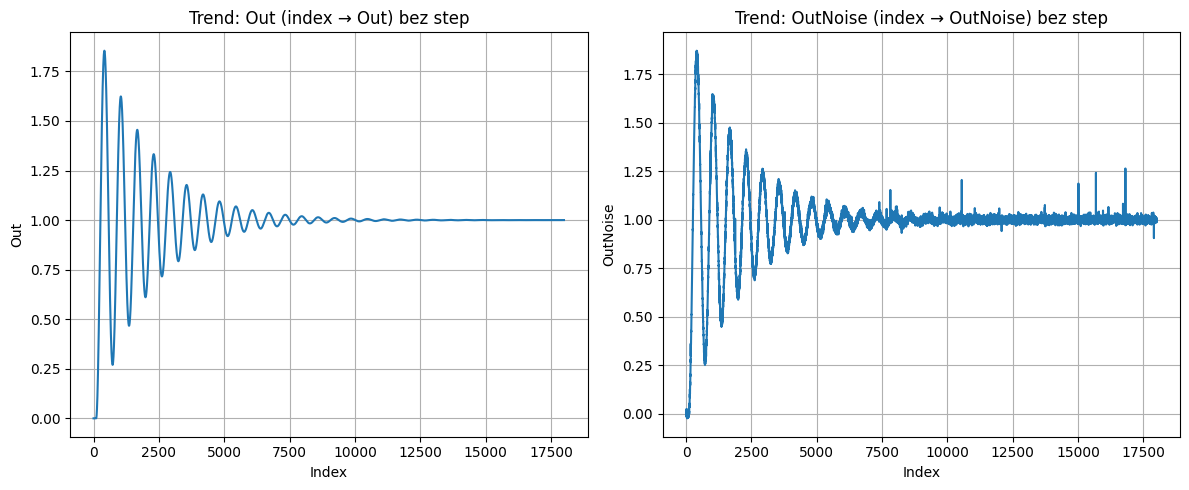

In [13]:
#wyrysuj przebiegi
#transmitacja drugiego rzędu - tłumienie dzeta=0.1
#dane z matlab

# dane jako numpy
out = df_tda["Out"].to_numpy()
out_noise = df_tda["OutNoise"].to_numpy()

# automatyczny index 0..N-1
index = df_tda.index.to_numpy()
plt.figure(figsize=(12,5))

# Out
plt.subplot(1,2,1)
plt.plot(index, out)
plt.title("Trend: Out (index → Out) bez step")
plt.xlabel("Index")
plt.ylabel("Out")
plt.grid(True)

# OutNoise
plt.subplot(1,2,2)
plt.plot(index, out_noise)
plt.title("Trend: OutNoise (index → OutNoise) bez step")
plt.xlabel("Index")
plt.ylabel("OutNoise")
plt.grid(True)

plt.tight_layout()
plt.show()


In [4]:
#przypisanie
step = df_tda["Step"].to_numpy()
out = df_tda["Out"].to_numpy()
out_noise = df_tda["OutNoise"].to_numpy()

In [5]:
import numpy as np

def takens_embedding(x, m=3, tau=5):
    """
    x: 1D array
    m: wymiar osadzania
    tau: opóźnienie
    """
    n = len(x) - (m - 1) * tau
    if n <= 0:
        raise ValueError("Za mało danych na takie m i tau")
    return np.column_stack([x[i : i + n] for i in range(0, m * tau, tau)])

def estimate_tau_autocorr(x, max_lag=200):
    """
    Prosty wybór tau: pierwszy lag, gdzie autokorelacja spada poniżej 1/e.
    """
    x = x - np.mean(x)
    ac = np.correlate(x, x, mode="full")
    ac = ac[ac.size // 2:]
    ac = ac / ac[0]
    thr = 1/np.e
    for lag in range(1, min(max_lag, len(ac))):
        if ac[lag] < thr:
            return lag
    return 5  # fallback

tau_out = estimate_tau_autocorr(out)
tau_noise = estimate_tau_autocorr(out_noise)

m = 3  # na start 3D, potem możesz dać 4-6

X_out = takens_embedding(out, m=m, tau=tau_out)
X_noise = takens_embedding(out_noise, m=m, tau=tau_noise)

print(X_out.shape, X_noise.shape)
print("tau_out =", tau_out, "tau_noise =", tau_noise)


(17759, 3) (17759, 3)
tau_out = 121 tau_noise = 121


Geometria systemu - pierwszy etap TDA
Rysuje trójwymiarową trajektorię sygnału po embeddingu Takensa
X_out (czysty sygnał)
X_noise (zaszumiony)


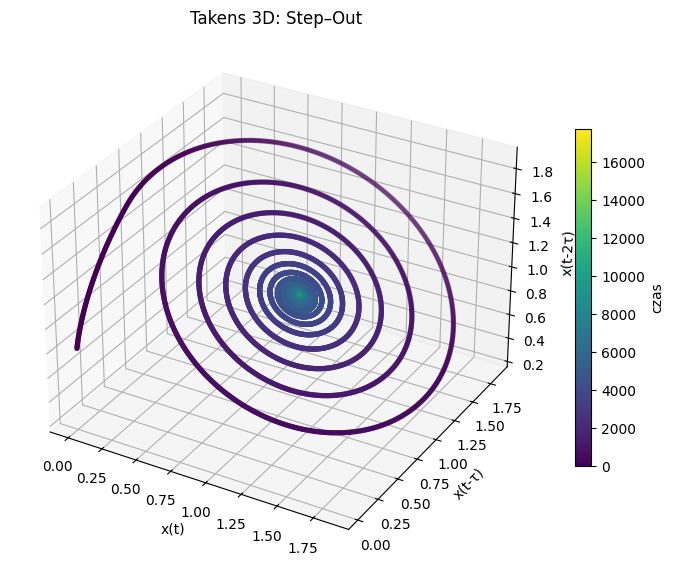

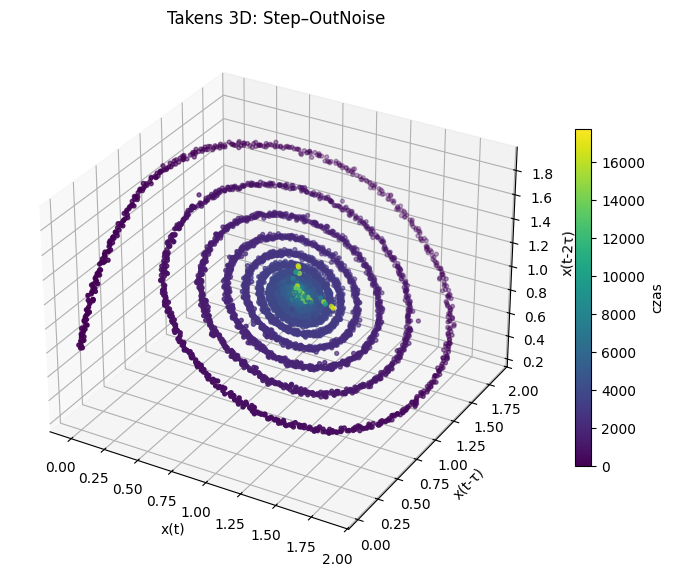

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_embedding_3d(X, title):
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection="3d")
    t = np.arange(len(X))
    sc = ax.scatter(X[:,0], X[:,1], X[:,2], c=t, s=8)
    ax.set_title(title)
    ax.set_xlabel("x(t)")
    ax.set_ylabel(f"x(t-τ)")
    ax.set_zlabel(f"x(t-2τ)")
    plt.colorbar(sc, ax=ax, shrink=0.6, label="czas")
    plt.tight_layout()
    plt.show()

plot_embedding_3d(X_out, "Takens 3D: Step–Out")
plot_embedding_3d(X_noise, "Takens 3D: Step–OutNoise")


In [16]:
!pip install ripser
from ripser import ripser
from persim import plot_diagrams

#obliczenie persystentnej homologii (PH) dla X_out
dgms_out = ripser(
    X_out,
    maxdim=1,
    n_perm=1200   # liczba landmarków
)["dgms"]

dgms_noise = ripser(
    X_noise,
    maxdim=1,
    n_perm=1200
)["dgms"]



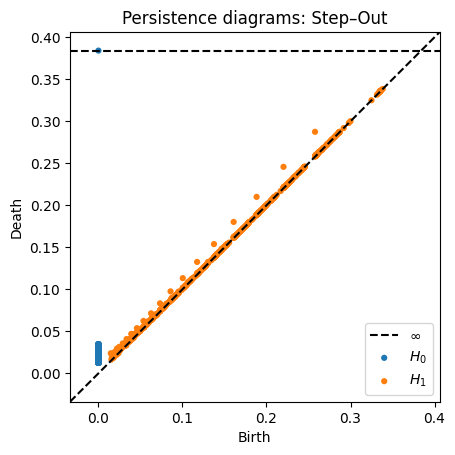

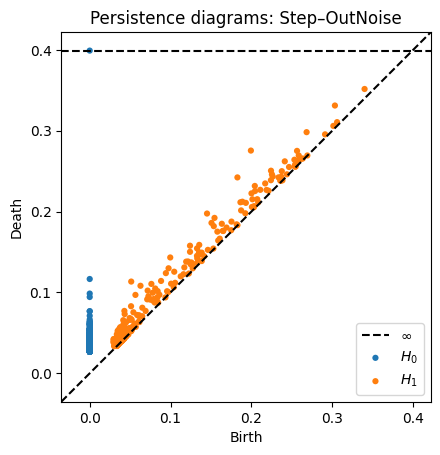

In [17]:
plot_diagrams(dgms_out, show=True, title="Persistence diagrams: Step–Out")
plot_diagrams(dgms_noise, show=True, title="Persistence diagrams: Step–OutNoise")


dla czystego out
#H0
H0 składa się tylko z kilku, bardzo krótkich punktów przy osi birth ≈ 0.
dane tworzą jedną spójną trajektorię.
Jeden punkt ma „śmierć = ∞” (niebieska kropka na górze) → oznacza, że ostatecznie wszystko łączy się w jedną komponentę = synał równy wymuszeniu

dla zaszumionego outNoise
H0 jest gęstsze i bardziej rozproszone.Więcej punktów nie leży ciasno przy przekątnej → noise wprowadza dużo małych „fałszywych klastrów”.
szum powoduje powstawanie lokalnych minimów/maksów → więcej krótkich, chaotycznych obiektów H0.
#H1
dla czystego - pomarańczowe punkty leżą blisko przekątnej, ale tworzą wyraźną linię narastania.sygnał cykliczny  (mała dynamiczna pętla w przestrzeni fazowej).
Niektóre punkty są nieco dalej od przekątnej (ale nie bardzo daleko) → struktura jest słaba, ale jest czytelna.

dla zaszumionego
Pomarańczowych punktów jest dużo więcej → noise generuje fałszywe pętle.
Punkty są rozproszone, gęste, wypełniają większy obszar.żadna pętla nie jest daleko od przekątnej → nie ma stabilnej struktury.

Szum ma wpływ na strukturę H1 (pętle) – sygnał traci cykliczność.
Szum niszczy też H0 – powstaje masa krótkich komponentów → lokalna chaotyczność.

In [9]:
from persim import bottleneck

# H0
bot0 = bottleneck(dgms_out[0], dgms_noise[0])

# H1
bot1 = bottleneck(dgms_out[1], dgms_noise[1])

print("Bottleneck H0 =", bot0)
print("Bottleneck H1 =", bot1)


/usr/local/lib/python3.12/dist-packages/persim/bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/persim/bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Bottleneck H0 = 0.05830497667193413
Bottleneck H1 = 0.03018280863761902


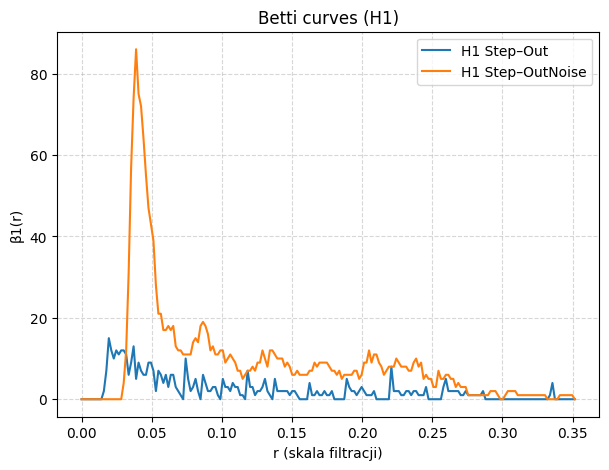

In [10]:
def betti_curve(dgm, r_vals):
    """
    dgm: (birth, death) for one dimension
    r_vals: array of radii
    """
    b = dgm[:,0]
    d = dgm[:,1]
    # usuwamy nieskończone zgony (np. w H0)
    mask = np.isfinite(d)
    b, d = b[mask], d[mask]
    return np.array([( (b <= r) & (r < d) ).sum() for r in r_vals])

# zakres r na bazie danych H1 (żeby był sensowny)
r_max = max(np.nanmax(dgms_out[1][:,1]), np.nanmax(dgms_noise[1][:,1]))
r_vals = np.linspace(0, r_max, 200)

beta1_out = betti_curve(dgms_out[1], r_vals)
beta1_noise = betti_curve(dgms_noise[1], r_vals)

plt.figure(figsize=(7,5))
plt.plot(r_vals, beta1_out, label="H1 Step–Out")
plt.plot(r_vals, beta1_noise, label="H1 Step–OutNoise")
plt.title("Betti curves (H1)")
plt.xlabel("r (skala filtracji)")
plt.ylabel("β1(r)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()


Betti curve β₁(r) pokazuje, że w czystym sygnale Step–Out występuje tylko jedna słaba, tłumiona pętla (oscylacja), natomiast w sygnale Step–OutNoise szum wytwarza dziesiątki krótkich cykli topologicznych przy małych skalach filtracji, co odpowiada zanikowi struktury i dominacji chaotycznych fluktuacji.